In [10]:
# Download July 2021 Green Taxi data
!curl -L -o green.csv.gz https://github.com/DataTalksClub/nyc-tlc-data/releases/download/green/green_tripdata_2021-07.csv.gz

# Unzip
!gunzip -f green.csv.gz

# Verify file
!ls -lh green.csv
!head -n 5 green.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1525k  100 1525k    0     0  3086k      0 --:--:-- --:--:-- --:--:-- 3086k
-rw-r--r-- 1 root root 7.3M Sep 16 03:29 green.csv
VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
1,2021-07-01 00:30:52,2021-07-01 00:35:36,N,1,74,168,1,1.20,6,0.5,0.5,0,0,,0.3,7.3,2,1,0
2,2021-07-01 00:25:36,2021-07-01 01:01:31,N,1,116,265,2,13.69,42,0.5,0.5,0,0,,0.3,43.3,2,1,0
2,2021-07-01 00:05:58,2021-07-01 00:12:00,N,1,97,33,1,.95,6.5,0.5,0.5,2.34,0,,0.3,10.14,1,1,0
2,2021-07-01 00:41:40,2021-07-01 00:47:23,N,1,74,42,1,1.24,6.5,0.5,0.5,0,0,,0.3,

In [11]:
import pandas as pd

# Load CSV
df = pd.read_csv("green.csv")
print("Shape:", df.shape)
df.head()


/tmp/ipython-input-505429414.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("green.csv")


Shape: (83691, 20)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,1.0,2021-07-01 00:30:52,2021-07-01 00:35:36,N,1.0,74,168,1.0,1.20,6.0,0.5,0.5,0.00,0.0,NaN,0.3,7.30,2.0,1.0,0.0
1,2.0,2021-07-01 00:25:36,2021-07-01 01:01:31,N,1.0,116,265,2.0,13.69,42.0,0.5,0.5,0.00,0.0,NaN,0.3,43.30,2.0,1.0,0.0
2,2.0,2021-07-01 00:05:58,2021-07-01 00:12:00,N,1.0,97,33,1.0,0.95,6.5,0.5,0.5,2.34,0.0,NaN,0.3,10.14,1.0,1.0,0.0
3,2.0,2021-07-01 00:41:40,2021-07-01 00:47:23,N,1.0,74,42,1.0,1.24,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,2.0,1.0,0.0
4,2.0,2021-07-01 00:51:32,2021-07-01 00:58:46,N,1.0,42,244,1.0,1.10,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2.0,1.0,0.0


In [15]:
# Parse datetimes
df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"], errors="coerce")
df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"], errors="coerce")

# Drop invalid rows
df = df.dropna(subset=["lpep_pickup_datetime", "lpep_dropoff_datetime"])

# Compute duration (seconds)
df["duration_sec"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).dt.total_seconds().astype(int)

# Filter out invalid/negative trips
df = df[df["duration_sec"] > 0]

# Extract pickup hour
df["pickup_hour"] = df["lpep_pickup_datetime"].dt.hour

print("After cleaning:", df.shape)
df[[  "lpep_pickup_datetime", "lpep_dropoff_datetime",
    "passenger_count", "trip_distance", "fare_amount",
    "total_amount", "payment_type", "duration_sec", "pickup_hour"]].head()


After cleaning: (83609, 22)


,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,payment_type,duration_sec,pickup_hour
0,2021-07-01 00:30:52,2021-07-01 00:35:36,1.0,1.20,6.0,7.30,2.0,284,0
1,2021-07-01 00:25:36,2021-07-01 01:01:31,2.0,13.69,42.0,43.30,2.0,2155,0
2,2021-07-01 00:05:58,2021-07-01 00:12:00,1.0,0.95,6.5,10.14,1.0,362,0
3,2021-07-01 00:41:40,2021-07-01 00:47:23,1.0,1.24,6.5,7.80,2.0,343,0
4,2021-07-01 00:51:32,2021-07-01 00:58:46,1.0,1.10,7.0,8.30,2.0,434,0


In [13]:
from sqlalchemy import create_engine

# Create local SQLite DB
engine = create_engine("sqlite:///nyc_taxi.db")

# Write to DB
df.to_sql("green_trips", engine, if_exists="replace", index=False)

# Verify
pd.read_sql("SELECT COUNT(*) as trip_count FROM green_trips;", engine)

,trip_count
0,83609


In [21]:
# 1. Average trip duration by passenger count
q1 = """
SELECT
  passenger_count,
  ROUND(AVG(duration_sec)/60.0, 1) AS avg_duration_min,
  COUNT(*) AS trips
FROM green_trips
WHERE passenger_count BETWEEN 1 AND 6          -- realistic range
  AND duration_sec BETWEEN 60 AND 7200         -- 1 min to 2 hours
GROUP BY passenger_count
ORDER BY passenger_count;
"""
print(pd.read_sql(q1, engine).head())

# 2. Trips by pickup hour
q2 = """
SELECT
  strftime('%H', lpep_pickup_datetime) AS pickup_hour,
  COUNT(*) AS trips
FROM green_trips
WHERE passenger_count IS NOT NULL
  AND CAST(passenger_count AS INTEGER) BETWEEN 1 AND 6
  AND duration_sec BETWEEN 60 AND 7200
GROUP BY pickup_hour
ORDER BY pickup_hour;
"""
print(pd.read_sql(q2, engine))

# 3. Revenue by payment type
q3 = """
SELECT
  payment_type,
  ROUND(SUM(total_amount), 2) AS total_revenue,
  COUNT(*) AS trips
FROM green_trips
WHERE total_amount IS NOT NULL
  AND total_amount > 0
  AND duration_sec BETWEEN 60 AND 7200
  AND passenger_count IS NOT NULL
  AND CAST(passenger_count AS INTEGER) BETWEEN 1 AND 6
GROUP BY payment_type
ORDER BY total_revenue DESC;
"""
print(pd.read_sql(q3, engine))

   passenger_count  avg_duration_min  trips
0              1.0              16.6  42336
1              2.0              19.5   3770
2              3.0              17.3    591
3              4.0              17.1    177
4              5.0              13.8   1206
   pickup_hour  trips
0           00    763
1           01    508
2           02    338
3           03    272
4           04    215
5           05    387
6           06    974
7           07   1727
8           08   2585
9           09   2827
10          10   3050
11          11   3092
12          12   2988
13          13   2827
14          14   3217
15          15   3585
16          16   3402
17          17   3469
18          18   3707
19          19   3027
20          20   2014
21          21   1633
22          22   1334
23          23   1142
   payment_type  total_revenue  trips
0           1.0      643005.13  28969
1           2.0      264711.18  19731
2           3.0        1485.20    123
3           4.0         183.95    

In [22]:
# 4. Top pickup locations (zones) by trip volume

q4 = """
SELECT
  PULocationID,
  COUNT(*) AS trips,
  ROUND(AVG(duration_sec)/60.0, 1) AS avg_duration_min
FROM green_trips
WHERE passenger_count IS NOT NULL
  AND CAST(passenger_count AS INTEGER) BETWEEN 1 AND 6
  AND duration_sec BETWEEN 60 AND 7200
GROUP BY PULocationID
ORDER BY trips DESC
LIMIT 10;
"""
print(pd.read_sql(q4, engine))

   PULocationID  trips  avg_duration_min
0            74   7925              12.6
1            75   6999              12.5
2            41   4050              12.3
3            42   2329              12.3
4           166   2090              13.1
5            95   2012              15.1
6           244   1832              17.2
7            65   1327              17.7
8            97   1317              17.7
9             7   1306              14.4


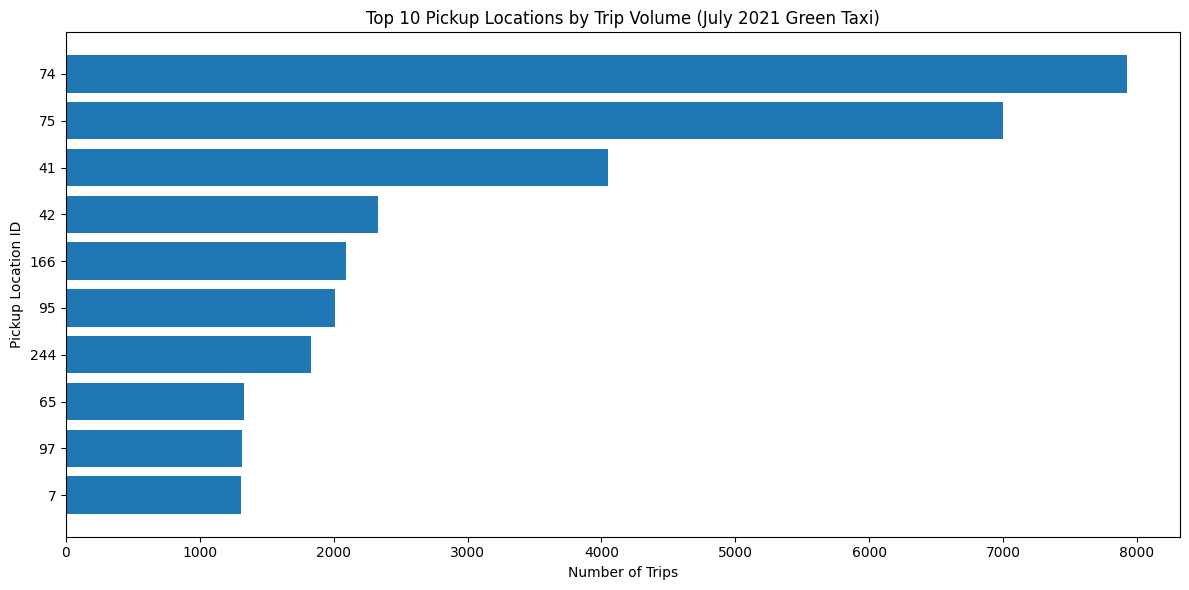

In [27]:
# --- rebuild a clean view ---
clean = df[
    df["passenger_count"].notna()
    & df["passenger_count"].between(1, 6)
    & df["duration_sec"].between(60, 7200)
]

# q4 in Python: top 10 pickup locations by trip volume (using PULocationID)
q4_pd = (clean
         .groupby("PULocationID", as_index=False)
         .agg(trips=("PULocationID", "size"),
              avg_duration_min=("duration_sec", lambda x: x.mean()/60.0))
         .sort_values("trips", ascending=False)
         .head(10))

# --- Visualization (horizontal bar chart) ---
import matplotlib.pyplot as plt

q4_sorted = q4_pd.sort_values("trips", ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(q4_sorted["PULocationID"].astype(str), q4_sorted["trips"])
plt.xlabel("Number of Trips")
plt.ylabel("Pickup Location ID")
plt.title("Top 10 Pickup Locations by Trip Volume (July 2021 Green Taxi)")
plt.tight_layout()
plt.show()
